<a href="https://colab.research.google.com/github/jessegrabowski/odsc-west-2025-pytensor/blob/main/notebooks/01_gaussian_process_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pymc as pm

import pytensor
import pytensor.tensor as pt
from pytensor.ipython import InteractiveRewrite

# Introduction to Gaussian Processes

GPs are used in machine learning as a predictive model for a whole dataset.  The ability to construct kernels / covariance functions that represent the known structure in the data and their ability to quantify uncertainty make them powerful tools.

GPs also have a role when doing Bayesian modeling in PPLs like PyMC, Stan, or Numpyro.  You might think about using a GP as a **prior distribution** when:
1. You need to regress out a more functional effect.  For example, a spatial or temporal relationship that you want to be able to represent.
2. **You need to do forecasting.  Unlike spline or polynomials, GPs can be used to make structured and interpretable extrapolations outside the domain of the observed data, making them useful for time series applications.**
3. When you have a hierarchical component in your model, but the groups aren't entirely exchangeable.

Each of these three tasks can serve as motivations to develop GPs.  In this tutorial we'll follow the second motivation.  

## What is a GP?

This can be a bit mind-bending when first introduced, but a Gaussian process is an **infinte dimensional multivariate normal distribution** that is parameterized by a covariance **function**, as opposed to a covariance matrix.  It's infinite dimensional because it *can* be evaluated at every point in the domain, even if it hasn't been yet.  To stay on theme, you can think of it as a multivariate normal that's evaluated over the data lazily.  To see what this means exactly, we need to first step back and define the covariance function, $k(x, x')$. 

### The covariance **function**

Instead of a covariance matrix with fixed size, we need to define a covariance *function* over every pair of $x$ points in the domain.  For the purpose of this introduction, it's OK to think of $x$ as the time index.  Here's the simplest covariance function, the "ExpQuad":
$$
k(x, x'; \ell) = \exp\left( \frac{-(x - x')^2}{2\ell^2} \right)
$$
which has one unknown parameter $\ell$, called the "lengthscale".  This covariance function describes data that has the property that $y$ values are more similar, if the $x$ values are more similar.  This makes sense in a time series context, and is a similar assumption as you'd make in an autoregressive process.  For example, if I weigh myself every day, my weight measurement on Tuesday is going to be more similar to my weight on Wednesday, than it will be to a measurement a year from now.  Exactly how similar is controlled by the lengthscale $\ell$, which is a learnable parameter.

Let's do a couple examples.  

#### Example 1, three time points.

Imagine we observe data at three points in time, $x = [1, 2, 3]$.  That could be day 1, day 2 and day 3.  Let's set $\ell = 1$, plug these numbers in and compute the covariance matrix.

In [2]:
x_sym = pt.tensor('x', shape=(None, 1))
x_prime_sym = pt.tensor('x_prime', shape=(None, 1))
ell_sym = pt.scalar('ell')

def exp_quad(x, x_prime, ell):
    return pt.exp(-(x - x_prime.T)**2 / (2 * ell**2))

k = pytensor.function([x_sym, x_prime_sym, ell_sym], exp_quad(x_sym, x_prime_sym, ell_sym))

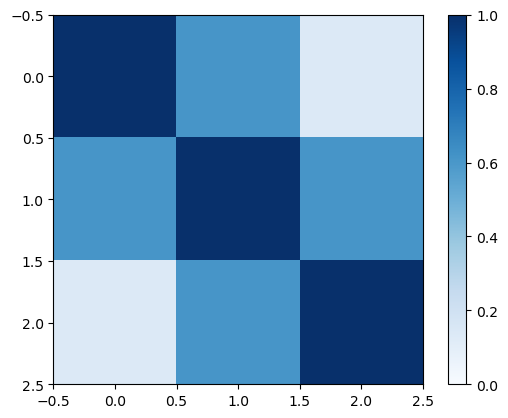

In [3]:
x = np.array([1, 2, 3])[:, None]
x_prime = x
ell = 1

plt.imshow(k(x, x_prime, ell), vmin=0, vmax=1, cmap="Blues"); plt.colorbar();

### Example 2, 5 time points

In this example we'll space the time points a little differently, and we'll put them out of order to show that the order doesn't matter.

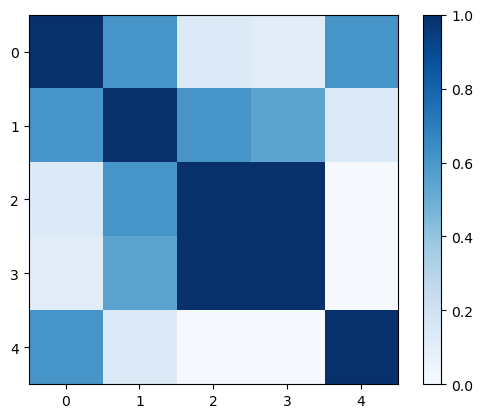

In [4]:
x = np.array([1, 2, 3, 3.1, 0])[:, None]
x_prime = x
ell = 1

plt.imshow(k(x, x_prime, ell), vmin=0, vmax=1, cmap="Blues"); plt.colorbar();

We can notice a few things here:

- The upper left 3x3 section is the same as we calculated before, since those $x$ values are the same.
- The row 5, column 1 element, corresponding to $k(x=1, x'=0)$ is the same as the $k(x=1, x'=2)$, because the distance between those $x$ values is the same.
- The row 3, column 4 element (and equivalently, row 4 column 3), corresponding to $k(x=3, x'=3.1)$ is very nearly 1.0, because these $x$ values are almost identical.  

## Bringing it Back

We can use GPs as priors over some component in our model, or directly over data.  Strong correlations created by the covariance function impart smoothness and regularization on the process being modeled.  Let's create a GP prior and draw a few samples to see this. 

We create a length 20 $x$ vector of equally spaced points. 

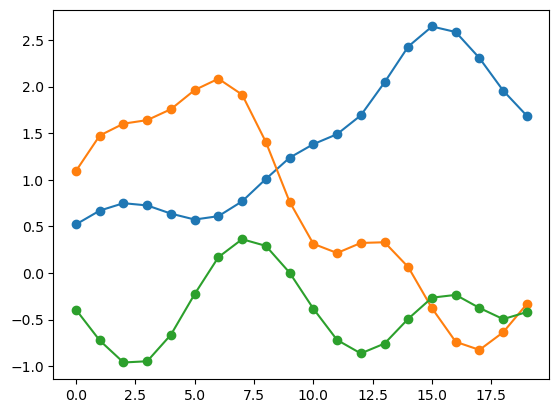

In [5]:
x = np.arange(20)[:, None]
x_prime = x
ell = 3

K = k(x, x_prime, ell)

n_draws = 3
s = pm.draw(pm.MvNormal.dist(mu=np.zeros(len(x)), cov=K), n_draws)

plt.plot(x, s.T, 'o-');

You might ask: 
> This is a draw from 20 dimensional multivariate normal, and sure it's starting to look like data.  How does that relate to a GP, which you said was infinite dimensional?

Look at the lines connecting the dots.  There is an infinite number of $x$ points we *could* evaluate the covariance function over, we just haven't done that.  This is what I meant by GPs are infinite dimensional multivariate normals *that are lazily evaluated*.  Let's simulate infinity by using lots of closely spaced $x$ points over the same domain. 

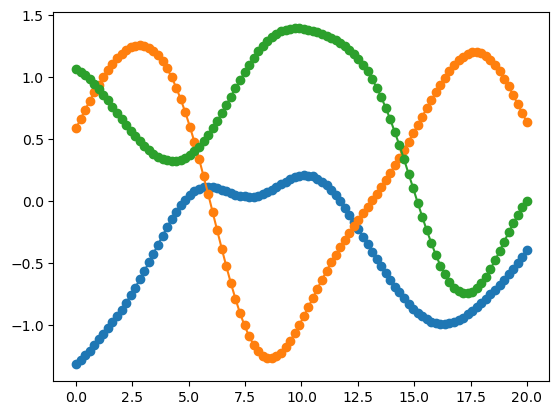

In [6]:
x = np.linspace(0, 20, 100)[:, None]
x_prime = x
ell = 3

K = k(x, x_prime, ell)

n_draws = 3
s = pm.draw(pm.MvNormal.dist(mu=np.zeros(len(x)), cov=K + 1e-6 * np.eye(x.shape[0])), n_draws)
plt.plot(x, s.T, 'o-');

These three draws are clearly represent the same process, and are much smoother because the $x$ points we choose are more closely together.  If we had a big enough computer we could increase the length of $x$ to infinity and make the same plot.  This is the sense how GPs are infinite dimensional multivariate normals.  This idea also underlies how we make predictions with them.  It's possible to forecast the GP posterior at new $x$ points, because the process was already defined over those anyway.

# Why GPs in PyTensor?

One of the points we're trying to get across in this tutorial is why use PyTensor to either back your project, or to get work done.  We're working on developing a GP library, and improving the GP functinality that already exists in PyMC.  Think GPJax, GPFflow, GPyTorch, or GPy, but built on PyTensor.  The reason we want to use PyTensor is because of the symbolic optimizations it does, particularly for linear algebra.  The trick with working with GPs in practice is to use approximations.  These libraries are essentially different implementations of approximations.  Sometimes they are purely linear algebra based.  For instance the "Kronecker GP".  Instead of writing a separate implementation of this, like these other libraries have to do (or relying on the COLA library, as does GPJax), this is something that PyTensor can do for us automatically under the hood. There are still more linear algebra rules to include, but we can write down the basic expressions we need for GPs, or the various approximations, and PyTensor can handle the linear algebra simplifications for us.  This will simplify the codebase, making easier to hack on, fix, use and learn from.

The first example is a basic GP model, using the ExpQuad covariance we defined above. 

# It's All About Multivariate Normals

This is the "G" part of GPs.  Ultimately working with GPs means evaluating the log probability of multivariate normals.  In practice, because GPs don't scale well with dataset size, this means working with approximations to this expression.  That may be linear algebra tricks, coming up with variational bounds, clever training routines, or some combination of these.  Since PyTensor can act as a symbolic math library, it's able to handle the first of those concerns, and greatly assists in solving the second.  

## The log-probability distribution of a multivariate normal

The log-probability of a multivariate normal is written as
$$
\log p(y \mid \mu, \Sigma) = \frac{1}{(2\pi)^{p/2} \det(\Sigma)^{1/2}} \exp\left[-0.5(y - \mu)^T \Sigma^{-1} (y - \mu)\right]
$$
The two tricky peices are the matrix inverse on $\Sigma$ and the determinant, $\det(\Sigma)$.  Calculating these terms directly is inefficient and leads to numerical errors.  The main thing we know up front is that $\Sigma$ will always be symmetric and positive semi-definite, since it's a covariance matrix. 

Because of this, we know the Cholesky decomposition is the best way to decompose $\Sigma$ into $\Sigma = L L^T$.  

### The determinant term

This is the most straightforward one to look at first.  We can exploit some linear algebra identities to make this calculation trivial, at least once the Cholesky decomposition is done.

1. The determinant of the product of matrices is equal to the product of their determinants, $\det(\Sigma) = \det(L)\det(L^T)$.
2. The determinant of a matrix transpose is the same as the determinant of the matrix, $\det(L) = \det(L^T)$.
3. For a triangular matrix (which the Cholesky factor $L$ is), the determinant is the product of the diagonal entries, $\det(L) = \prod{L_{ii}}$.

Let's see how many of these PyTensor can do for us automatically as rewrites.

#### 1. Determinant of a product

In [7]:
A = pt.dmatrix('A')
A.tag.lower_triangular = True

B = pt.dmatrix('B')
B.tag.lower_triangular = True

out = pt.linalg.det(A @ B)
InteractiveRewrite(out)

Whoops, no it didn't do it automatically.  PyTensor's linear algebra rewrite rules are pretty incomplete at this stage, PRs welcome!  Let's try the next one.

#### 2. Determinant of a transpose

In [8]:
A = pt.dmatrix('A')

out = pt.linalg.det(A.T)
InteractiveRewrite(out)

Even though it's a very fast operation, PyTensor unnecessarily took the transpose of $A$.  

#### 3. Determinant of a triangular matrix

Which is the product of the diagonal entries.

In [9]:
A = pt.dmatrix('A')
A.tag.lower_triangular = True

out = pt.linalg.det(A)
InteractiveRewrite(out)

Ouch, so far we're 0/3.  All this rewrite did was remove the blockwise designation.  All of these are straightforward to add to the PyTensor rewrite database though.  Let's try a slightly easier one.  

#### 4.1. Determinant of a diagonal matrix

In [10]:
a = pt.dvector('a')

A = pt.diag(a)
out = pt.linalg.det(A)

InteractiveRewrite(out)

There we go, this time the right thing happened.  You'll notice that the original graph is quite long, and the simplifications really do a great job of simplifying the calculation.  

#### 4.2 Distributing the Cholesky decomposition over a Kronecker product

There's another interesting rewrite that PyTensor knows how to do that will help greatly with GPs.  The fact that something like the Cholesky distributions over the Kronecker product, $\text{chol}(A \otimes B) = \text{chol}(A) \otimes \text{chol}(B)$.  This is really powerful because the size of a $A \otimes B$ is $mn \times mn$, when $A$ is $m \times m$ and $B$ is $n \times n$.  So it is much much faster to do two Cholesky decompositions on small matrices than one on one big matrix. 

This and other associated operations come up when your x data is located on grid, for example, in some spatial applications. Taking advantage of Kronecker structure is a huge efficiency boost, going from $\mathcal{O}(m^3n^3)$ to $\mathcal{O}(m^3 + n^3)$.  Instead of having to write a separate imlpementation for a GP to take advantage of this, we can have it built into PyTensor and have it have it handled automatically.  

In [11]:
K1 = pt.dmatrix('K1')
K2 = pt.dmatrix('K2')
K = pt.linalg.kron(K1, K2)
L = pt.linalg.cholesky(K)

InteractiveRewrite(L)

### The quadratic term

Next is the quadratic term, $\exp\left[-0.5(y - \mu) \Sigma^{-1} (y - \mu)\right]$, where the tricky part is dealing with the matrix inverse.  I'm sure many of you have heard that doing matrix inverses directly is a bad idea, which it is.  And PyTensor knows that too.  Let's simplify the expression a bit and see what PyTensor does with our inverse.

In [12]:
mu = pt.dvector('mu')
Sigma = pt.dmatrix('K')

out = pt.linalg.inv(Sigma) @ mu
InteractiveRewrite(out)

Nailed it. It converted the inverse into a solve.  That means we can actually write `pt.linalg.inv(Sigma)` like our inner C student really wants to and not end up with bad code. Let's see how clever we can get.  What we really need to do is reuse the Cholesky factor we computed for the determinant.  So we'll see how close PyTensors rewrites can get us.  

##### The answer

Before we start PyTensoring, let's work out manually the analog solution.

$$
\begin{align}
(y - \mu)^T \Sigma^{-1} (y - \mu) &= (y - \mu)^T (L L^T)^{-1} (y - \mu) \\
                                &= (y - \mu)^T L^{-T} L^{-1} (y - \mu) \\
                                &= ((L^{-1}(y - \mu))^{T}(L^{-1}(y - \mu))
\end{align}
$$
To see the rewrites done, we'll break it down into steps again.

In [13]:
y = pt.dvector('y')
mu = pt.dvector('mu')

Sigma = pt.dmatrix('Sigma')
Sigma.tag.psd = True
Sigma.tag.symmetric = True

out = (y - mu).T @ pt.linalg.inv(Sigma) @ (y - mu) 
InteractiveRewrite(out)

PyTensor nails it!  Notice on the end result:
- SolveTriangular instead of Solve, it's taking advantage of the fact that the Cholesky factor is a triangular matrix.
- It's reusing the Cholesky factor, not recomputing it each time. Same with the $y - \mu$ part.
- It replaced basic matrix multiplication with the specialized CGemv Lapack routine.

The result uses two triangular solves and reuses the Cholesky factor to calculate the result, exactly the way we want it to.

### Full Answer

Next, let's bring the determinant stuff back in.  Let's see if PyTensor is smart enough to take advantage of that Cholesky factor we have floating around to calculate the determinant efficiently.  I'm going to neglect the exponential and the various scalar factors floating around to keep the computational graph a little bit simpler. 

In [14]:
y = pt.dvector('y')
mu = pt.dvector('mu')
Sigma = pt.dmatrix('Sigma')
Sigma.tag.psd = True
Sigma.tag.symmetric = True

out = (1.0 / pt.sqrt(pt.linalg.det(Sigma))) * (y - mu).T @ pt.linalg.inv(Sigma) @ (y - mu)
InteractiveRewrite(out)

And it does!  So in summary, we very naively wrote out the computation directly using `pt.linalg.det` and `pt.linalg.inv`, and PyTensor automatically turned it into the most efficient way to calculate it.  These things aren't implemented yet, but the rewrite system builds on itself.  For instance, there is work being done to build out functionality for sparse matrices and banded matrices, both of which are relevant to GPs.  Toeplitz structure is another place where optimizations are possible. A similar project that we're paying a lot of attention to is [CoLA](https://github.com/wilson-labs/cola), which is used by GPJax and offers compute backends in Jax, PyTorch and some NumPy.  CoLA stands for "Compositional Linear Algebra".  The full functionality of CoLA is what we're aiming to reproduce.  Except, unlike CoLA, PyTensor doesn't only apply to linear algebra.  As you've seen, all operations are potentially in scope for rewrites, not just ones matrices.  

In [15]:
a = pt.dvector('a')
b = pt.dvector('b')

out = pt.log(a * pt.exp(b))
InteractiveRewrite(out)

In [16]:
y = pt.dvector('y')

Sigma = pt.dmatrix('Sigma')
Sigma.tag.psd = True
Sigma.tag.symmetric = True

k = Sigma.shape[0]
logp = pt.log((2*pt.pi)**(-k/2) * pt.sqrt(pt.linalg.det(Sigma)) * pt.exp(-0.5 * y.T @ pt.linalg.inv(Sigma) @ y))

InteractiveRewrite(logp)

So the rewrites did what we wanted.  

# An actual example.  Fitting a GP

Next we're going to fit a real live example.  Personally, this is the shortest code I've ever seen for fitting a GP.  

In [17]:
y = pt.dvector('y')
x = pt.dvector('x')
x_prime = pt.dvector('x_prime')
eta = pt.scalar('eta')
ell = pt.scalar('ell')
sigma = pt.scalar('sigma')

K = eta**2 * pt.exp(-(x[:, None] - x_prime[None, :])**2 / (2 * ell**2))

k = K.shape[0]
Sigma = K + sigma**2 * pt.eye(k)

Sigma.tag.psd = True
Sigma.tag.symmetric = True

det_term = (1.0 / (2.0 * pt.pi)**(-k/2)) * (1.0 / pt.sqrt(pt.linalg.det(Sigma)))
quad_term = pt.exp(-0.5 * y.T @ pt.linalg.inv(Sigma) @ y)
neg_logp = -pt.log(det_term) - pt.log(quad_term)

You'll notice when defining the logp term, I didn't log the whole thing.  PyTensor is seems to be missing this little bit.  Notice that we can separate the work of defining the math we need to do, with the work of getting it ready to be minimized.  When you're designing a library, or something user facing, this type of stuff can be done behind the scenes.  But even still, it's not too much work.  What happens next is:

1. The hyperparameters we're optimizing need to be constrained to be positive.  The lengthscale, the scale `eta`, and the noise term all must be above zero. We can directly replace these nodes in the graph with versions that have a softmax function applied to them.
2. We need to take the three scalar hyperparameters, `ell`, `eta`, and `sigma` and arrange them into a vector for the `scipy.optimimze.minimize` function.
3. We then have to take the gradient, and then compile the negative logp and its gradient together into a single function.  Compiling them together allows PyTensor to reuse peices from the logp in the gradient, which also will greatly simplify the computations being performed.  

In [18]:
## Rewrite to contrain parameters to be positive
neg_logp = pytensor.graph.graph_replace(
    neg_logp,
    {
        eta: pt.softplus(eta),
        ell: pt.softplus(ell),
        sigma: pt.softplus(sigma),
    }
    
)

## rewrite to combine hyperparameters into a vecto
hyperparams = pt.dvector('hyperparams')
neg_logp = pytensor.graph.graph_replace(
    neg_logp, 
    {
        eta: hyperparams[0], 
        ell: hyperparams[1], 
        sigma: hyperparams[2], 
    }
)

neg_logp_grad = pt.stack(pt.grad(neg_logp, wrt=[hyperparams]))
training_func = pytensor.function([hyperparams, x, y, x_prime], [neg_logp, neg_logp_grad], mode="JAX")

Let's check out the compiled graph using `dprint`.  It's a lot longer now, but we can still stop the Choleskies, the triangular solves, and see that the Cholesky factor is being reused between the logp and its gradient (all have the same id).

In [19]:
training_func.dprint()

Sub [id A] 87
 ├─ Neg [id B] 86
 │  └─ Log [id C] 85
 │     └─ Reciprocal [id D] 84
 │        └─ Mul [id E] 83
 │           ├─ Pow [id F] 82
 │           │  ├─ 6.283185307179586 [id G]
 │           │  └─ Mul [id H] 81
 │           │     ├─ -0.5 [id I]
 │           │     └─ Shape_i{0} [id J] 3
 │           │        └─ x [id K]
 │           └─ Sqrt [id L] 42
 │              └─ Prod{axis=0} [id M] 41
 │                 └─ Sqr [id N] 40
 │                    └─ ExtractDiag{offset=0, axis1=0, axis2=1, view=True} [id O] 39
 │                       └─ Cholesky{lower=True, check_finite=False, on_error='raise', overwrite_a=False} [id P] 31
 │                          └─ Add [id Q] 30
 │                             ├─ Mul [id R] 29
 │                             │  ├─ Sqr [id S] 28
 │                             │  │  └─ ExpandDims{axes=[0, 1]} [id T] 27
 │                             │  │     └─ Scalar_softplus [id U] 26
 │                             │  │        └─ Subtensor{i} [id V] 25
 │   

## The data 

Here's the data we're going to model.  We are trying to recover the blue curve, which is a non-linear function.  So the non-parametric GP is a good fit.

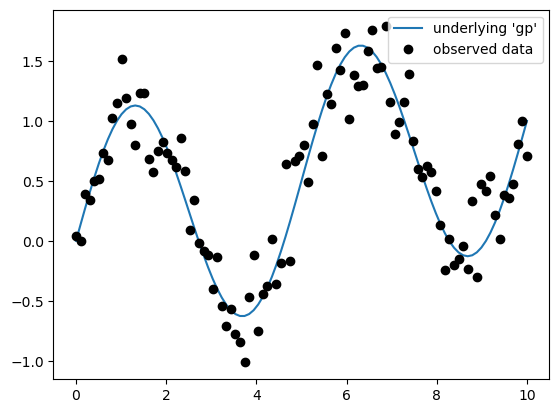

In [20]:
t_val = np.linspace(0, 10, 100)
f = np.sin(2 * np.pi * t_val * 0.2) + 0.1 * t_val
noise = 0.25 * np.random.randn(len(t_val))
y_val = f + noise
plt.plot(t_val, f, label="underlying 'gp'");
plt.plot(t_val, y_val, 'ok', label="observed data");
plt.legend();

Let's plug what we got into `minimize`.

In [21]:
import scipy

res = scipy.optimize.minimize(
    fun=training_func,
    x0=np.array([0.0, 0.0, 0.0]),
    args=(t_val, y_val, t_val),
    jac=True,
    method='L-BFGS-B',
)

In [22]:
res

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: -164.05243031339268
        x: [ 2.687e-01  7.550e-01 -1.311e+00]
      nit: 10
      jac: [[-3.612e-06 -1.496e-05 -1.359e-04]]
     nfev: 12
     njev: 12
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

All the hyperparameter values look reasonable.  The value for sigma is right on.

In [23]:
pt.softplus(res.x).eval()

array([0.83649143, 1.14023636, 0.23858781])

## The GP prediction

Since PyTensor is awesome, we can implement the prediction equation directly.  I'm taking this right out of the book "Gaussian Processes for Machine Learning" by Rassmussen and Williams.

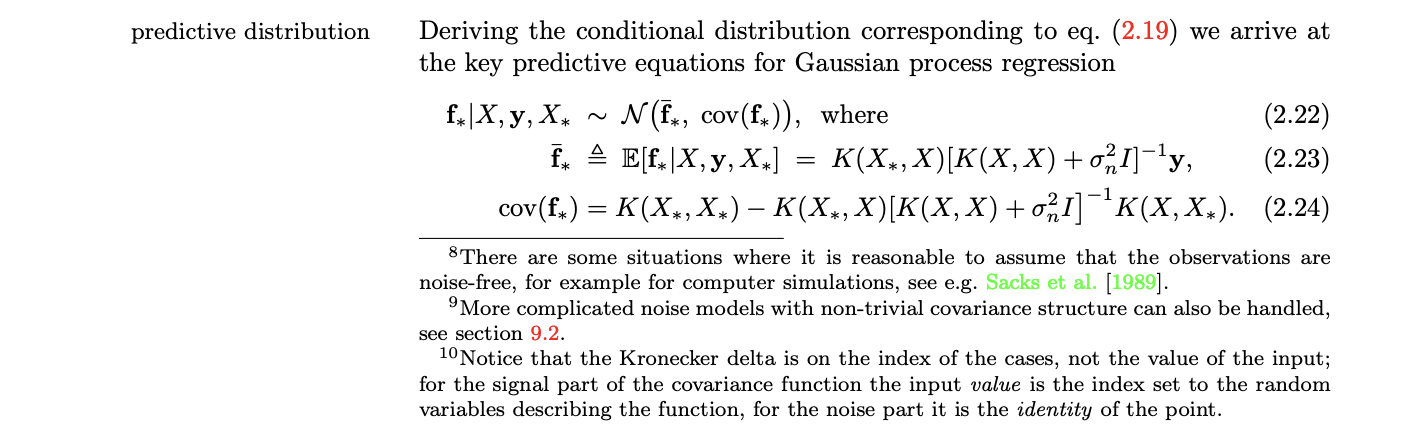

In [24]:
y = pt.dvector('y')

x = pt.dvector('x')
xs = pt.dvector('xs')
eta = pt.scalar('eta')
ell = pt.scalar('ell')
sigma = pt.scalar('sigma')

def expquad(x1, x2, eta, ell):
    return eta**2 * pt.exp(-(x1[:, None] - x2[None, :])**2 / (2 * ell**2))
    
Kxx = expquad(x, x, eta, ell)
Ksx = expquad(xs, x, eta, ell)
Kxs = expquad(x, xs, eta, ell)
Kss = expquad(xs, xs, eta, ell)

k = Kxx.shape[0]

fmu_star = Ksx @ pt.linalg.inv(Kxx + sigma**2 * pt.eye(k)) @ y
Sigma_star = Kss - Ksx @ pt.linalg.inv(Kxx + sigma**2 * pt.eye(k)) @ Kxs
Sigma_star_corrected = Sigma_star + 1e-6 * pt.eye(k) # small numerical correction for positive definite-ness

draws = pt.iscalar('draws')
f_star = pt.random.multivariate_normal(mean=fmu_star, cov=Sigma_star_corrected, size=draws)

In [25]:
draw_func = pytensor.function([y, x, xs, eta, ell, sigma, draws], [f_star])

In [26]:
ts_val = np.linspace(0, 15, 100)

eta_val, ell_val, sigma_val = pt.softplus(res.x).eval()

n_draws = 120
s = draw_func(y_val, t_val, ts_val, eta_val, ell_val, sigma_val, n_draws)[0]

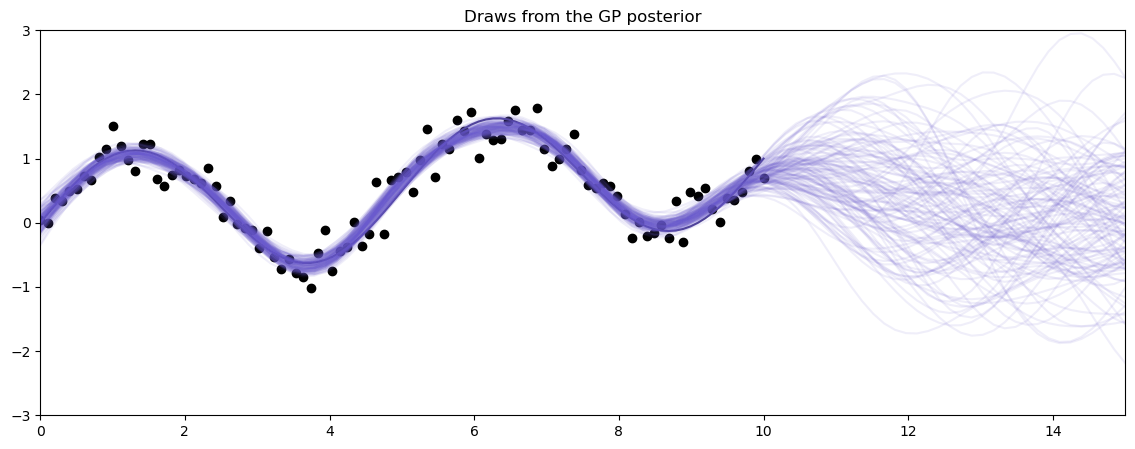

In [27]:
plt.figure(figsize=(14, 5))
plt.plot(t_val, y_val, 'ok')
plt.plot(t_val, f, color='darkslateblue');
plt.plot(ts_val, s.T, color='slateblue', alpha=0.1);
plt.ylim([-3, 3]); plt.xlim([0, 15]);
plt.title("Draws from the GP posterior");

# Summary

- Building a GP in PyTensor isn't too much harder than building a logistic regression model.
- Linear algebra rewrites allow PyTensor to automatically combine different GP approximations.  For example, Kronecker structer with optimizing a variational lower bound.
- Being able to manipulate nodes in a graph allows you to swap variables.  For example, applying positivity constraints to various parameters without cluttering up the overall code of the algorithm.
- Manipulating nodes also allows one to rewrite to match the formats needed by downstream components, like `scipy.optimize.minimize`, without affecting the algorithm.
- You can write your math in a straightforward way, and PyTensor will figure out how to compute it in a performant and efficient way.  The graph can be checked, and it's not hard to add additional rewrite rules.  For the actual computation, it'll then dispatch the result to different backends.  Right now it supports Jax, C, MLX, and Numba.
- PyTensor comes from Theano, the first deep learning framework.  The core of it is old and very battle tested.  It's easy to add the latest and greatest computational backend, so you don't need to worry about hitching your wagon to a particular compute framework.